In [1]:
from __future__ import division
from pyomo.opt import SolverFactory
from pyomo.environ import *
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm
import seaborn as sns
from pyomo.opt import SolverStatus, TerminationCondition

In [ ]:
def Co_optimization(inputfile, efficiency, solver="gurobi"):
    # Read all price data

    price = inputfile['price'].to_dict()
    netload = inputfile['Demand (kW)'].to_dict()


    with SolverFactory(solver) as opt:
        # Creation of a Concrete Model
            model = ConcreteModel()


            # ###### Set
            model.t = Set(initialize=range(96))

            # ###### Parameters

            # Price
            model.price_energy = Param(model.t, initialize=price, doc='Energy Price')
            model.net_load = Param(model.t, initialize = netload, doc = 'net load')


            # ###### Variable
            model.energy_charge = Var(model.t, domain=NonNegativeReals, doc='charge power')
            model.energy_discharge = Var(model.t, domain=NonNegativeReals, doc='discharge power')
            #model.SOE = Var(model.t, domain=NonNegativeReals, initialize= inisoc, doc='charge power')
            model.V = Var(domain = NonNegativeReals, doc = 'added demand charge cost')

            # define 0-1 variable
            model.u = Var(model.t, within=Binary, doc='positive energy sign')
            model.v = Var(model.t, within=Binary, doc='negative energy sign')


            # ###### Rules
            def maximum_chargepower_rule(model, t):
                return model.energy_charge[t]<= model.u[t] * 400
            model.chargepower_max_rule1 = Constraint(model.t, rule=maximum_chargepower_rule, doc='Pcharge max rule')

            def maximum_dischargepower_rule(model, t):
                return model.energy_discharge[t]<= model.v[t] * 400
            model.dischargepower_max_rule2 = Constraint(model.t, rule=maximum_dischargepower_rule, doc='Pdischarge max rule')


            def uv_rule(model,t):
                return model.u[t] + model.v[t] <= 1
            model.uvtime = Constraint(model.t, rule=uv_rule, doc='not charge and discharge simultanously')


            def minimum_energy_rule(model, t):
                return sum(model.energy_charge[i]*efficiency - model.energy_discharge[i] for i in range(0, t + 1))/4 >= -400
            model.minimum_energy_rule = Constraint(model.t, rule=minimum_energy_rule, doc='E min rule')

            def maximum_energy_rule(model, t):
                return sum(model.energy_charge[i]*efficiency - model.energy_discharge[i] for i in range(0, t + 1))/4 <= 400
            model.maximum_energy_rule = Constraint(model.t, rule=maximum_energy_rule, doc='E max rule')

#             def demand_charge_rule(model,t):
#                 return (model.net_load[t] + model.energy_charge[t] - model.energy_discharge[t]*efficiency) <= 570
#             model.demand_charge_rule = Constraint(model.t, rule=demand_charge_rule, doc='cannot exceed demand charge')

            def demand_charge_rule(model, t):
                return 20 * (model.energy_charge[t] - model.energy_discharge[t]*efficiency + model.net_load[t]-545) <= model.V
            model.demand_charge_rule = Constraint(model.t, rule=demand_charge_rule, doc='cannot exceed demand charge')

            def objective_rule(model):
                return sum((model.energy_charge[i] - model.energy_discharge[i]*efficiency + model.net_load[i])
                           * model.price_energy[i]  for i in model.t)/4 + model.V
            model.objective = Objective(rule=objective_rule, sense=minimize, doc='Define objective function')
            
#             def objective_rule(model):
#                 return sum((model.energy_charge[i] - model.energy_discharge[i]*efficiency + model.net_load[i])
#                            * model.price_energy[i]  for i in model.t)/4 + 20 * norm([model.energy_charge[i] - model.energy_discharge[i]*efficiency + model.net_load[i]-545
#                                    for i in model.t],ord = numpy.inf)
#             model.objective = Objective(rule=objective_rule, sense=minimize, doc='Define objective function')

            results = opt.solve(model)

            result_charge = []
            result_discharge = []


            for i in model.energy_charge:
                result_charge.append(value(model.energy_charge[i]))
            for i in model.energy_discharge:
                result_discharge.append(value(model.energy_discharge[i]))
            optimalresult = pd.DataFrame(
                {'energy charge' : result_charge,
                 'energy discharge' : result_discharge}
            )


            print value(model.objective)
            print value(model.V)
            model.load(results) # Loading solution into results object

            if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
                print 'Got the optimal solution!'
            elif (results.solver.termination_condition == TerminationCondition.infeasible):
                print 'No infeasible solution!'
            else:
                # Something else is wrong
                print ('Solver Status:', results.solver.status)


    return optimalresult

In [2]:
# Assume everyday the departure time and arrival time follows uniform
# distribution (8:00, -10:00) departure time (4:00- 6:00)

#generate start time and end time for 50 EVs
ArrTime = [round(i) for i in np.random.uniform(31,41,50)]
DepTime = [round(i) for i in np.random.uniform(63,73,50)]
TimeTable = pd.DataFrame({'Arrival time': ArrTime, 'Departure time': DepTime})

# Create the 0-1 table to show the plug-in time
PlugTime = [[0 for i in range(96)] for j in range(50)]
for x in range(50):
    index = 0
    while index < 96:
        if index > TimeTable['Arrival time'].iloc[x] and index < TimeTable['Departure time'].iloc[x]:
            PlugTime[x][index] = 1
        else:
            PlugTime[x][index] = 0
        index += 1

PlugTimeTable = pd.DataFrame(PlugTime)

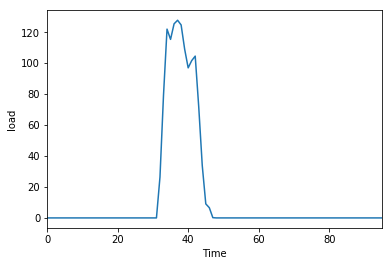

In [14]:
#calculate uncontroll charging load
energy_consump = np.random.uniform(5/3.75, 40/3.75, 50)

charge_activity = [[0 for i in range(96)] for j in range(50)]
cum_energy = 0
for i in range(50):
    for j in range(96):
        if PlugTimeTable.iloc[i][j] == 1 and energy_consump[i] - cum_energy >= 6.6/4:
            charge_activity[i][j] = 6.6
            cum_energy += 6.6/4
            
        elif PlugTimeTable.iloc[i][j] == 1 and cum_energy < energy_consump[i] and energy_consump[i] - cum_energy <6.6/4:
            charge_activity[i][j] = (energy_consump[i] - cum_energy) * 4
            cum_energy = 0
            break
        else:
            charge_activity[i][j] = 0
    
EV_Load = pd.DataFrame(charge_activity).sum(axis = 0)
EV_Load.plot()
plt.xlabel("Time") 
plt.ylabel("load")
plt.show()

In [6]:
# Load the load and price data
opt_input = pd.read_excel('data.xlsx', sheetname=0, header=0, index_col=None)
print opt_input['Energy Price ($/kWh)']





0     0.217
1     0.217
2     0.217
3     0.217
4     0.217
5     0.217
6     0.217
7     0.217
8     0.217
9     0.217
10    0.217
11    0.217
12    0.217
13    0.217
14    0.217
15    0.217
16    0.217
17    0.217
18    0.217
19    0.217
20    0.217
21    0.217
22    0.217
23    0.217
24    0.217
25    0.217
26    0.217
27    0.217
28    0.217
29    0.217
      ...  
66    0.268
67    0.268
68    0.268
69    0.268
70    0.268
71    0.268
72    0.244
73    0.244
74    0.244
75    0.244
76    0.244
77    0.244
78    0.244
79    0.244
80    0.244
81    0.244
82    0.244
83    0.244
84    0.244
85    0.244
86    0.217
87    0.217
88    0.217
89    0.217
90    0.217
91    0.217
92    0.217
93    0.217
94    0.217
95    0.217
Name: Energy Price ($/kWh), Length: 96, dtype: float64


In [ ]:
# # Optimization
myresult = Co_optimization(opt_input, 0.92)

SOEchange =numpy.cumsum([myresult['energy charge'][i] * 0.92 / 4 - myresult['energy charge'][i] / 4 for i in range(96)])
SOE = [SOEchange[i] + 400 for i in range(96)]

#print myresult.model.energy
myresult.to_csv('battery_schedule.csv',index_label='15min')

In [ ]:
change = [myresult['energy charge'][i]*0.92 - myresult['energy discharge'][i] for i in range(96)]
SOEchange = numpy.cumsum(change)/4
SOE = [SOEchange[i] + 400 for i in range(96)]
output = pd.DataFrame({'col':SOE})
output.to_csv('batterySOE.csv')

In [ ]:
newtable = [[0 for i in range(50)] for j in range[96]]

In [ ]:
[[0 for i in range(3)] for j in range(4)]